In [1]:
!pip install simpy

In [2]:
import simpy
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [3]:
def simulate_cpu_scheduling(
    task_arrival_rate,
    task_execution_time,
    number_of_cpu_cores,
    simulation_time=10
):
    """
    Simulates CPU task scheduling and returns average task waiting time.
    """

    env = simpy.Environment()
    waiting_times = []

    def cpu_task(env, cpu):
        arrival_time = env.now
        with cpu.request() as request:
            yield request
            waiting_times.append(env.now - arrival_time)
            yield env.timeout(task_execution_time)

    def task_generator(env, cpu):
        while True:
            yield env.timeout(random.expovariate(task_arrival_rate))
            env.process(cpu_task(env, cpu))

    cpu_resource = simpy.Resource(env, capacity=number_of_cpu_cores)
    env.process(task_generator(env, cpu_resource))
    env.run(until=simulation_time)

    return np.mean(waiting_times)


In [4]:
TASK_ARRIVAL_RATE_RANGE = (1, 15)
TASK_EXECUTION_TIME_RANGE = (0.5, 3)
CPU_CORES_RANGE = (1, 8)

In [5]:
simulation_results = []

NUMBER_OF_SIMULATIONS = 1000

for _ in range(NUMBER_OF_SIMULATIONS):
    task_arrival_rate = random.uniform(*TASK_ARRIVAL_RATE_RANGE)
    task_execution_time = random.uniform(*TASK_EXECUTION_TIME_RANGE)
    number_of_cpu_cores = random.randint(*CPU_CORES_RANGE)

    average_waiting_time = simulate_cpu_scheduling(
        task_arrival_rate,
        task_execution_time,
        number_of_cpu_cores
    )

    simulation_results.append([
        task_arrival_rate,
        task_execution_time,
        number_of_cpu_cores,
        average_waiting_time
    ])

In [6]:
dataset = pd.DataFrame(
    simulation_results,
    columns=[
        "task_arrival_rate",
        "task_execution_time",
        "number_of_cpu_cores",
        "average_waiting_time"
    ]
)

dataset.head()

,task_arrival_rate,task_execution_time,number_of_cpu_cores,average_waiting_time
0,9.363317,2.877528,8,3.179585
1,12.538695,2.749167,8,3.224130
2,5.546578,1.232078,2,3.489010
3,1.341934,0.792857,8,0.000000
4,14.448345,2.308044,3,4.178969


In [7]:
X = dataset.drop("average_waiting_time", axis=1)
y = dataset["average_waiting_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regression": SVR()
}

In [9]:
model_performance = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    model_performance.append([
        model_name,
        mse,
        r2
    ])

In [10]:
results_table = pd.DataFrame(
    model_performance,
    columns=["Model Name", "Mean Squared Error", "R² Score"]
)

results_table.sort_values(by="Mean Squared Error")

,Model Name,Mean Squared Error,R² Score
4,Random Forest,0.154721,0.913816
5,Support Vector Regression,0.197646,0.889905
3,Decision Tree,0.230689,0.871499
1,Ridge Regression,0.340961,0.810073
0,Linear Regression,0.340996,0.810054
2,Lasso Regression,0.762951,0.575011


In [11]:
dataset.to_csv("simulation_dataset.csv", index=False)
results_table.to_csv("model_comparison_results.csv", index=False)

In [12]:
best_model = results_table.sort_values(
    by=["Mean Squared Error", "R² Score"],
    ascending=[True, False]
).iloc[0]

best_model

,4
Model Name,Random Forest
Mean Squared Error,0.154721
R² Score,0.913816


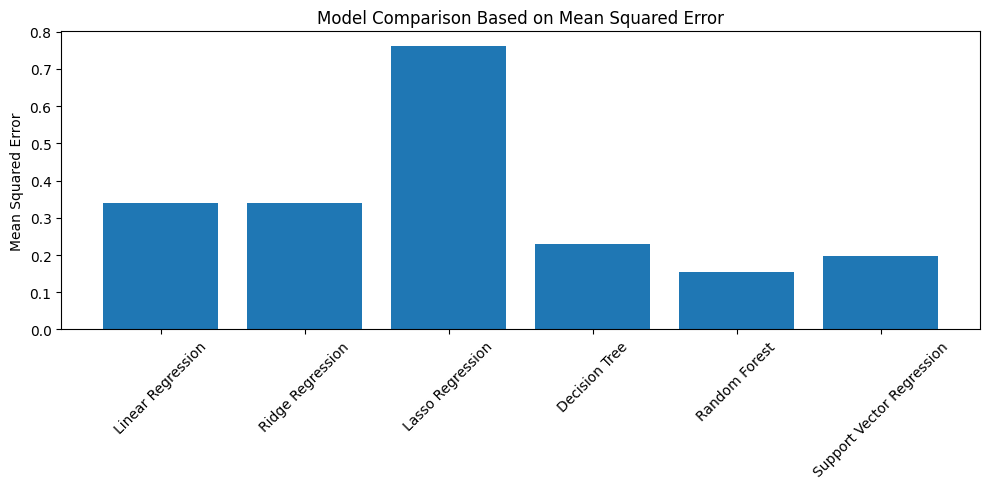

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(results_table["Model Name"], results_table["Mean Squared Error"])
plt.xticks(rotation=45)
plt.ylabel("Mean Squared Error")
plt.title("Model Comparison Based on Mean Squared Error")
plt.tight_layout()
plt.show()

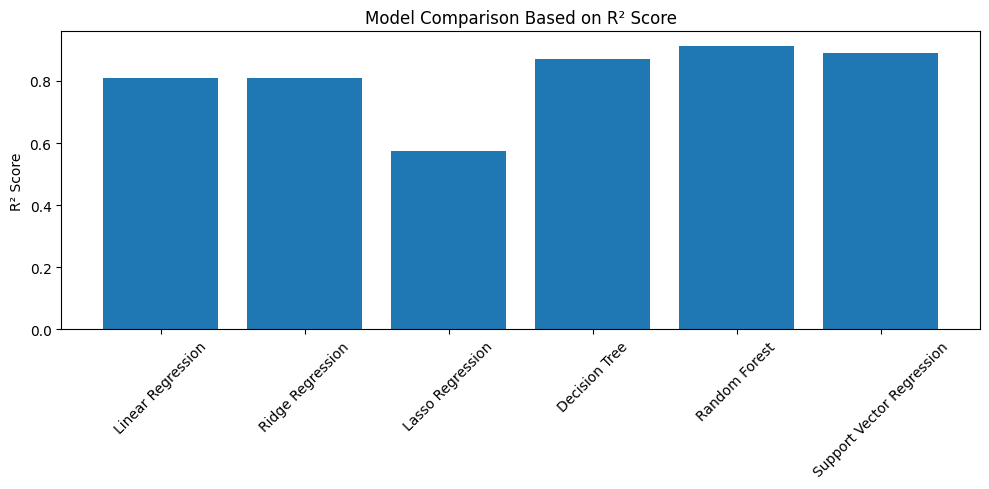

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(results_table["Model Name"], results_table["R² Score"])
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Model Comparison Based on R² Score")
plt.tight_layout()
plt.show()